# Models
### XGBoost adn MLP Classifier
Source: https://www.kaggle.com/vaibhav2025/airbnb-listings-reviews \
The dataset file is the original one preprocessed by PrepData notebook

In [158]:
#importing librariries
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.metrics import plot_confusion_matrix

In [159]:
#reading the prepared data
df = pd.read_csv('Airbnb_Data/modelListings.csv')
df.head(5)

,listing_id,name,host_since,host_location,host_is_superhost,host_total_listings_count,host_identity_verified,neighbourhood,latitude,longitude,...,balcony,Private_entrance,TV,Dedicated_workspace,Refrigerator,Cooking,Bathtub,Shower,price_category,price_catN
0,281420,"Beautiful Flat in le Village Montmartre, Paris",2011-12-03,"Paris, Ile-de-France, France",f,1.0,f,Buttes-Montmartre,48.88668,2.33343,...,False,False,False,False,False,False,False,False,Cheap,1.0
1,3705183,39 mÂ² Paris (Sacre CÅ“ur),2013-11-29,"Paris, Ile-de-France, France",f,1.0,t,Buttes-Montmartre,48.88617,2.34515,...,False,False,False,False,False,False,False,False,Average,2.0
2,4082273,"Lovely apartment with Terrace, 60m2",2014-07-31,"Paris, Ile-de-France, France",f,1.0,f,Elysee,48.88112,2.31712,...,False,False,True,False,False,False,False,False,Average,2.0
3,4797344,Cosy studio (close to Eiffel tower),2013-12-17,"Paris, Ile-de-France, France",f,1.0,t,Vaugirard,48.84571,2.30584,...,False,False,True,False,False,False,False,False,Cheap,1.0
4,4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,2014-12-14,"Paris, Ile-de-France, France",f,1.0,f,Passy,48.85500,2.26979,...,False,False,True,False,False,False,True,False,Cheap,1.0


In [160]:
df = df[df['price_catN'].notna()]

In [161]:
df['price_catN'] = df['price_catN'].astype(int)

In [162]:
df['price_catN'].value_counts()

2    21981
1    21706
3     3759
Name: price_catN, dtype: int64

### Splitting and preparing data for modelling

In [163]:
le = preprocessing.LabelEncoder()
y = df['price_catN']
X = df.drop(['name','price_category','price','listing_id','name','host_location', 'price_catN'], axis=1)
X = X.apply(le.fit_transform)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [165]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

### MLP Classifier
simple neural network from sklearn library

In [166]:
model = MLPClassifier(max_iter=100)
#specifying the parametres
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
#finding the best parametres
clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=3)
#training
clf.fit(train_scaled, y_train)

C:\Users\mates\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [167]:
#prediction
mlp_pred = clf.predict(test_scaled)

### Evaluation of MLP Classifier

In [168]:
mplFirst = accuracy_score(y_test, mlp_pred)
mplFirst

0.7160168598524763

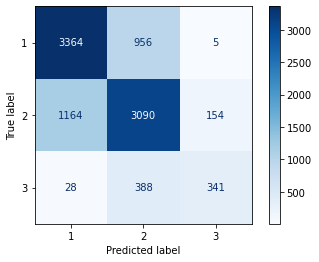

In [169]:
disp = plot_confusion_matrix(clf, test_scaled, y_test,
                                 cmap=plt.cm.Blues)
plt.show()

In [170]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


### XGBoost classifier

In [171]:
#parametres
params = {
        'n_estimators': stats.randint(150, 1000),
        'learning_rate': stats.uniform(0.01, 0.6),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0,2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6,7,8,9,10]

        }
xgb = XGBClassifier()
#choosing the best parametres
rs = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, n_jobs=-1, cv=5, verbose=3, random_state=1001 )
#training
rs.fit(train_scaled, y_train)

#prediction
y_pred = rs.best_estimator_.predict(test_scaled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\mates\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.72362726 0.72188852 0.7346929         nan]
  warnings.warn(
C:\Users\mates\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:09:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Evaluating XGBoost classifier

In [172]:
XGBFirst = accuracy_score(y_test, y_pred)
XGBFirst

0.7341412012644889

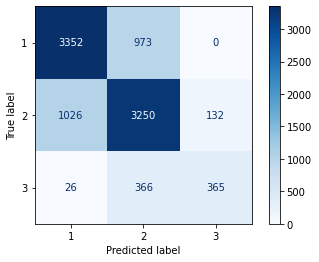

In [173]:
XGBcM = plot_confusion_matrix(rs.best_estimator_, test_scaled, y_test,
                                 cmap=plt.cm.Blues)

plt.show()

In [174]:
print('Best parameters found:\n', rs.best_params_)

Best parameters found:
 {'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.3388673683212176, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 424, 'subsample': 1.0}


In [175]:
importance = rs.best_estimator_.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.01271
Feature: 1, Score: 0.01505
Feature: 2, Score: 0.02602
Feature: 3, Score: 0.01049
Feature: 4, Score: 0.01716
Feature: 5, Score: 0.02628
Feature: 6, Score: 0.02446
Feature: 7, Score: 0.02922
Feature: 8, Score: 0.08454
Feature: 9, Score: 0.14022
Feature: 10, Score: 0.13194
Feature: 11, Score: 0.01289
Feature: 12, Score: 0.00932
Feature: 13, Score: 0.01672
Feature: 14, Score: 0.00976
Feature: 15, Score: 0.02032
Feature: 16, Score: 0.01414
Feature: 17, Score: 0.00910
Feature: 18, Score: 0.03390
Feature: 19, Score: 0.01072
Feature: 20, Score: 0.02093
Feature: 21, Score: 0.01132
Feature: 22, Score: 0.01914
Feature: 23, Score: 0.08117
Feature: 24, Score: 0.00934
Feature: 25, Score: 0.00971
Feature: 26, Score: 0.01307
Feature: 27, Score: 0.01138
Feature: 28, Score: 0.08183
Feature: 29, Score: 0.01915
Feature: 30, Score: 0.03144
Feature: 31, Score: 0.01721
Feature: 32, Score: 0.00934
Feature: 33, Score: 0.01002


<AxesSubplot:>

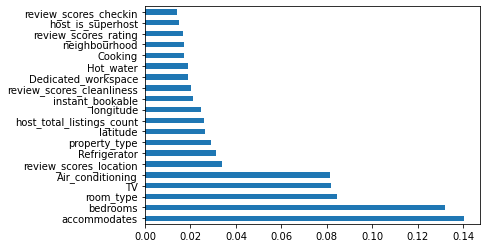

In [176]:
(pd.Series(rs.best_estimator_.feature_importances_, index=X.columns)
   .nlargest(20)
   .plot(kind='barh'))

## Subset of the most important features in the previous model
Creating a subset model

In [177]:
dfThin = df[['accommodates','bedrooms','room_type','Air_conditioning','TV','Refrigerator','review_scores_location','property_type','instant_bookable','price_catN']]
dfThin

,accommodates,bedrooms,room_type,Air_conditioning,TV,Refrigerator,review_scores_location,property_type,instant_bookable,price_catN
0,2,1.0,Entire place,False,False,False,10.0,Entire apartment,f,1
1,2,1.0,Entire place,False,False,False,10.0,Entire apartment,f,2
2,2,1.0,Entire place,False,True,False,10.0,Entire apartment,f,2
3,2,1.0,Entire place,False,True,False,10.0,Entire apartment,f,1
4,2,1.0,Entire place,False,True,False,10.0,Entire apartment,f,1
...,...,...,...,...,...,...,...,...,...,...
47463,2,1.0,Entire place,False,True,False,10.0,Entire apartment,f,2
47464,2,1.0,Entire place,False,True,False,10.0,Entire apartment,f,1
47465,2,1.0,Entire place,False,False,False,10.0,Entire apartment,f,1
47466,2,1.0,Entire place,False,True,False,10.0,Entire apartment,f,2


### Encoding, splitting and scaling data

In [178]:
le = preprocessing.LabelEncoder()
y = dfThin['price_catN']
X = dfThin.drop(['price_catN'], axis=1)
X = X.apply(le.fit_transform)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [180]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

### XGBoost classifier

In [181]:

#parametres
params = {
        'n_estimators': stats.randint(150, 1000),
        'learning_rate': stats.uniform(0.01, 0.6),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0,2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6,7,8,9,10]

        }
xgb = XGBClassifier()
#choosing the best parametres
rs = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, n_jobs=-1, cv=5, verbose=3, random_state=1001 )
#training
rs.fit(train_scaled, y_train)

#prediction
y_pred = rs.best_estimator_.predict(test_scaled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\mates\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.67414883 0.67464937 0.67791643        nan]
  warnings.warn(
C:\Users\mates\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:10:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


###  Evaluating the model
accuracy and confusion matrix

In [182]:
XGBThin = accuracy_score(y_test, y_pred)
XGBThin

0.6779768177028451

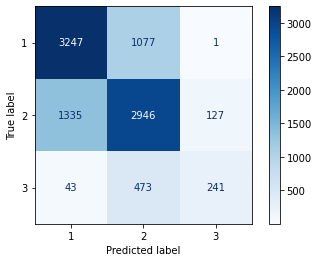

In [183]:
disp = plot_confusion_matrix(rs.best_estimator_, test_scaled, y_test,
                             cmap=plt.cm.Blues)

plt.show()

In [184]:
print('Best parameters found:\n', rs.best_params_)

Best parameters found:
 {'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.3388673683212176, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 424, 'subsample': 1.0}


<AxesSubplot:>

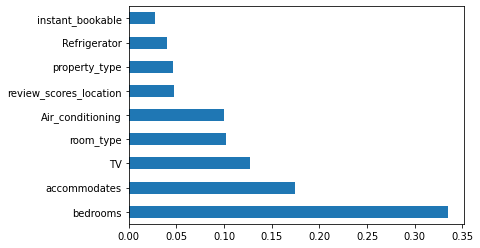

In [185]:
(pd.Series(rs.best_estimator_.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))

### MLP Classifier

In [186]:
model = MLPClassifier(max_iter=100)
#specifying the parametres
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
#finding the best parametres
clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5)
#training
clf.fit(train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [187]:
mlp_pred = clf.predict(test_scaled)

### Evaluating MLP Classifier

In [188]:
MLPThin = accuracy_score(y_test, mlp_pred)
MLPThin

0.6730242360379347

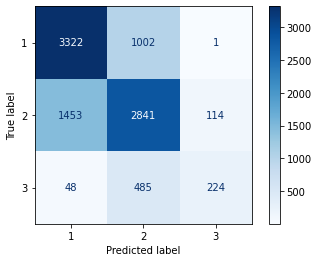

In [189]:
disp = plot_confusion_matrix(clf, test_scaled, y_test,
                                 cmap=plt.cm.Blues)

plt.show()

In [190]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


## Final results

In [191]:
print('First MLP Classifier acc:', mplFirst)
print('First XGBoost Classifier acc:', XGBFirst)
print('Thin MLP Classifier acc:', MLPThin)
print('Thin XGBoost Classifier acc:', XGBThin)

First MLP Classifier acc: 0.7160168598524763
First XGBoost Classifier acc: 0.7341412012644889
Thin MLP Classifier acc: 0.6730242360379347
Thin XGBoost Classifier acc: 0.6779768177028451
